In [1]:
import datetime
import time
current_time = datetime.datetime.now()
print(current_time)
timestamp = str(time.mktime(current_time.timetuple()))

2015-11-25 10:18:00.839747


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')
from pycalphad.fitting import build_pymc_model
from pycalphad import Database
import pymc
import numpy as np
import glob

input_database = Database('Al-Ni-start.tdb')
dataset_names = sorted(glob.glob('BCC_B2*.json'))

LB2ALVA_A = pymc.Normal('LB2ALVA_A', mu=0, tau=1./200000**2)
B2ALVA_A = pymc.Normal('B2ALVA_A', mu=0, tau=1./100000**2)
B2ALVA_B = pymc.Normal('B2ALVA_B', mu=0, tau=1./30**2)
LB2NIVA_A = pymc.Normal('LB2NIVA_A', mu=0, tau=1./100000**2)
LB2NIVA_B = pymc.Normal('LB2NIVA_B', mu=0, tau=1./30**2)
B2NIVA_A = pymc.Normal('B2NIVA_A', mu=0, tau=1./100000**2)
B2NIVA_B = pymc.Normal('B2NIVA_B', mu=0, tau=1./30**2)
LB2ALNI_A = pymc.Normal('LB2ALNI_A', mu=0, tau=1./100000**2)
LB2ALNI_B = pymc.Normal('LB2ALNI_B', mu=0, tau=1./30**2)
B2ALNI_A = pymc.Normal('B2ALNI_A', mu=0, tau=1./100000**2)
B2ALNI_B = pymc.Normal('B2ALNI_B', mu=0, tau=1./30**2)
params = [LB2ALVA_A, B2ALVA_A, B2ALVA_B, LB2NIVA_A,
          LB2NIVA_B, B2NIVA_A, B2NIVA_B, LB2ALNI_A,
          LB2ALNI_B, B2ALNI_A, B2ALNI_B]
%time mod, datasets = build_pymc_model(input_database, dataset_names, params)
M = pymc.MAP(mod)
%time M.fit()
MDL = pymc.MCMC(mod, db='hdf5', dbname='AlNi-BCC_B2-'+timestamp+'.hdf5', dbcomplevel=4, dbcomplib='bzip2')

CPU times: user 7.72 s, sys: 46 ms, total: 7.77 s
Wall time: 7.75 s
CPU times: user 5.37 s, sys: 2 ms, total: 5.37 s
Wall time: 5.36 s


In [3]:
%time MDL.sample(iter=10000, burn=8000, burn_till_tuned=False, thin=2, progress_bar=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 539.3 secCPU times: user 9min, sys: 278 ms, total: 9min
Wall time: 8min 59s


Plotting LB2ALNI_A
Plotting B2NIVA_A
Plotting LB2NIVA_A
Plotting B2ALNI_A
Plotting LB2NIVA_B
Plotting B2ALVA_A
Plotting B2NIVA_B
Plotting B2ALVA_B
Plotting LB2ALNI_B
Plotting B2ALNI_B
Plotting LB2ALVA_A


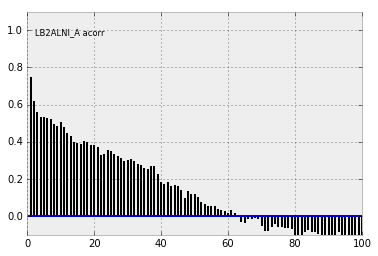

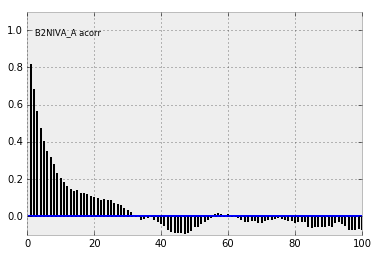

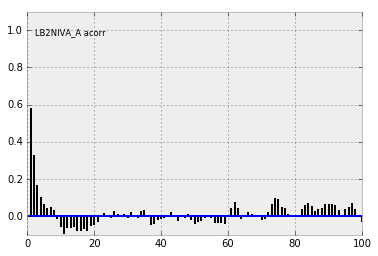

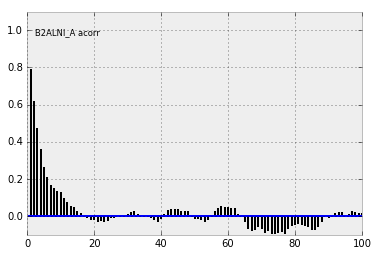

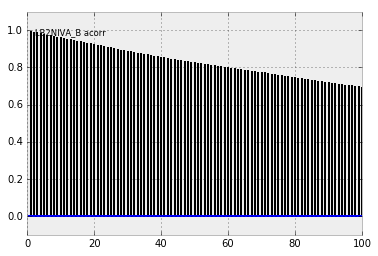

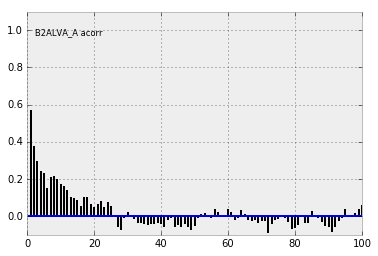

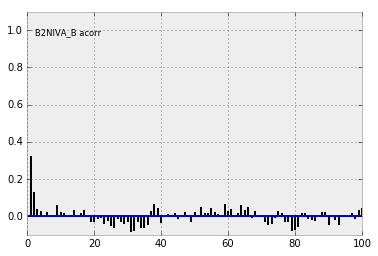

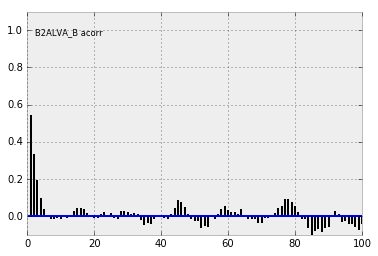

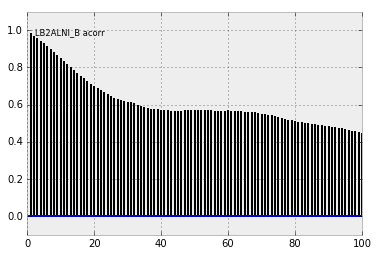

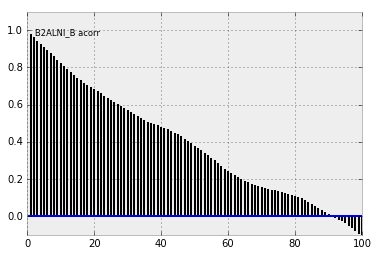

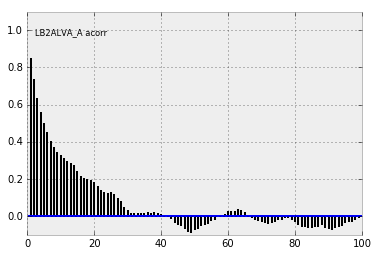

In [4]:
pymc.Matplot.autocorrelation(MDL)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


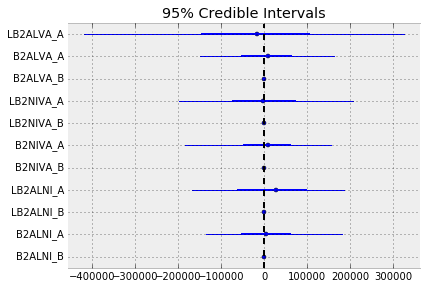

In [5]:
pymc.Matplot.summary_plot(params)

/home/rotis/anaconda/envs/mc/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


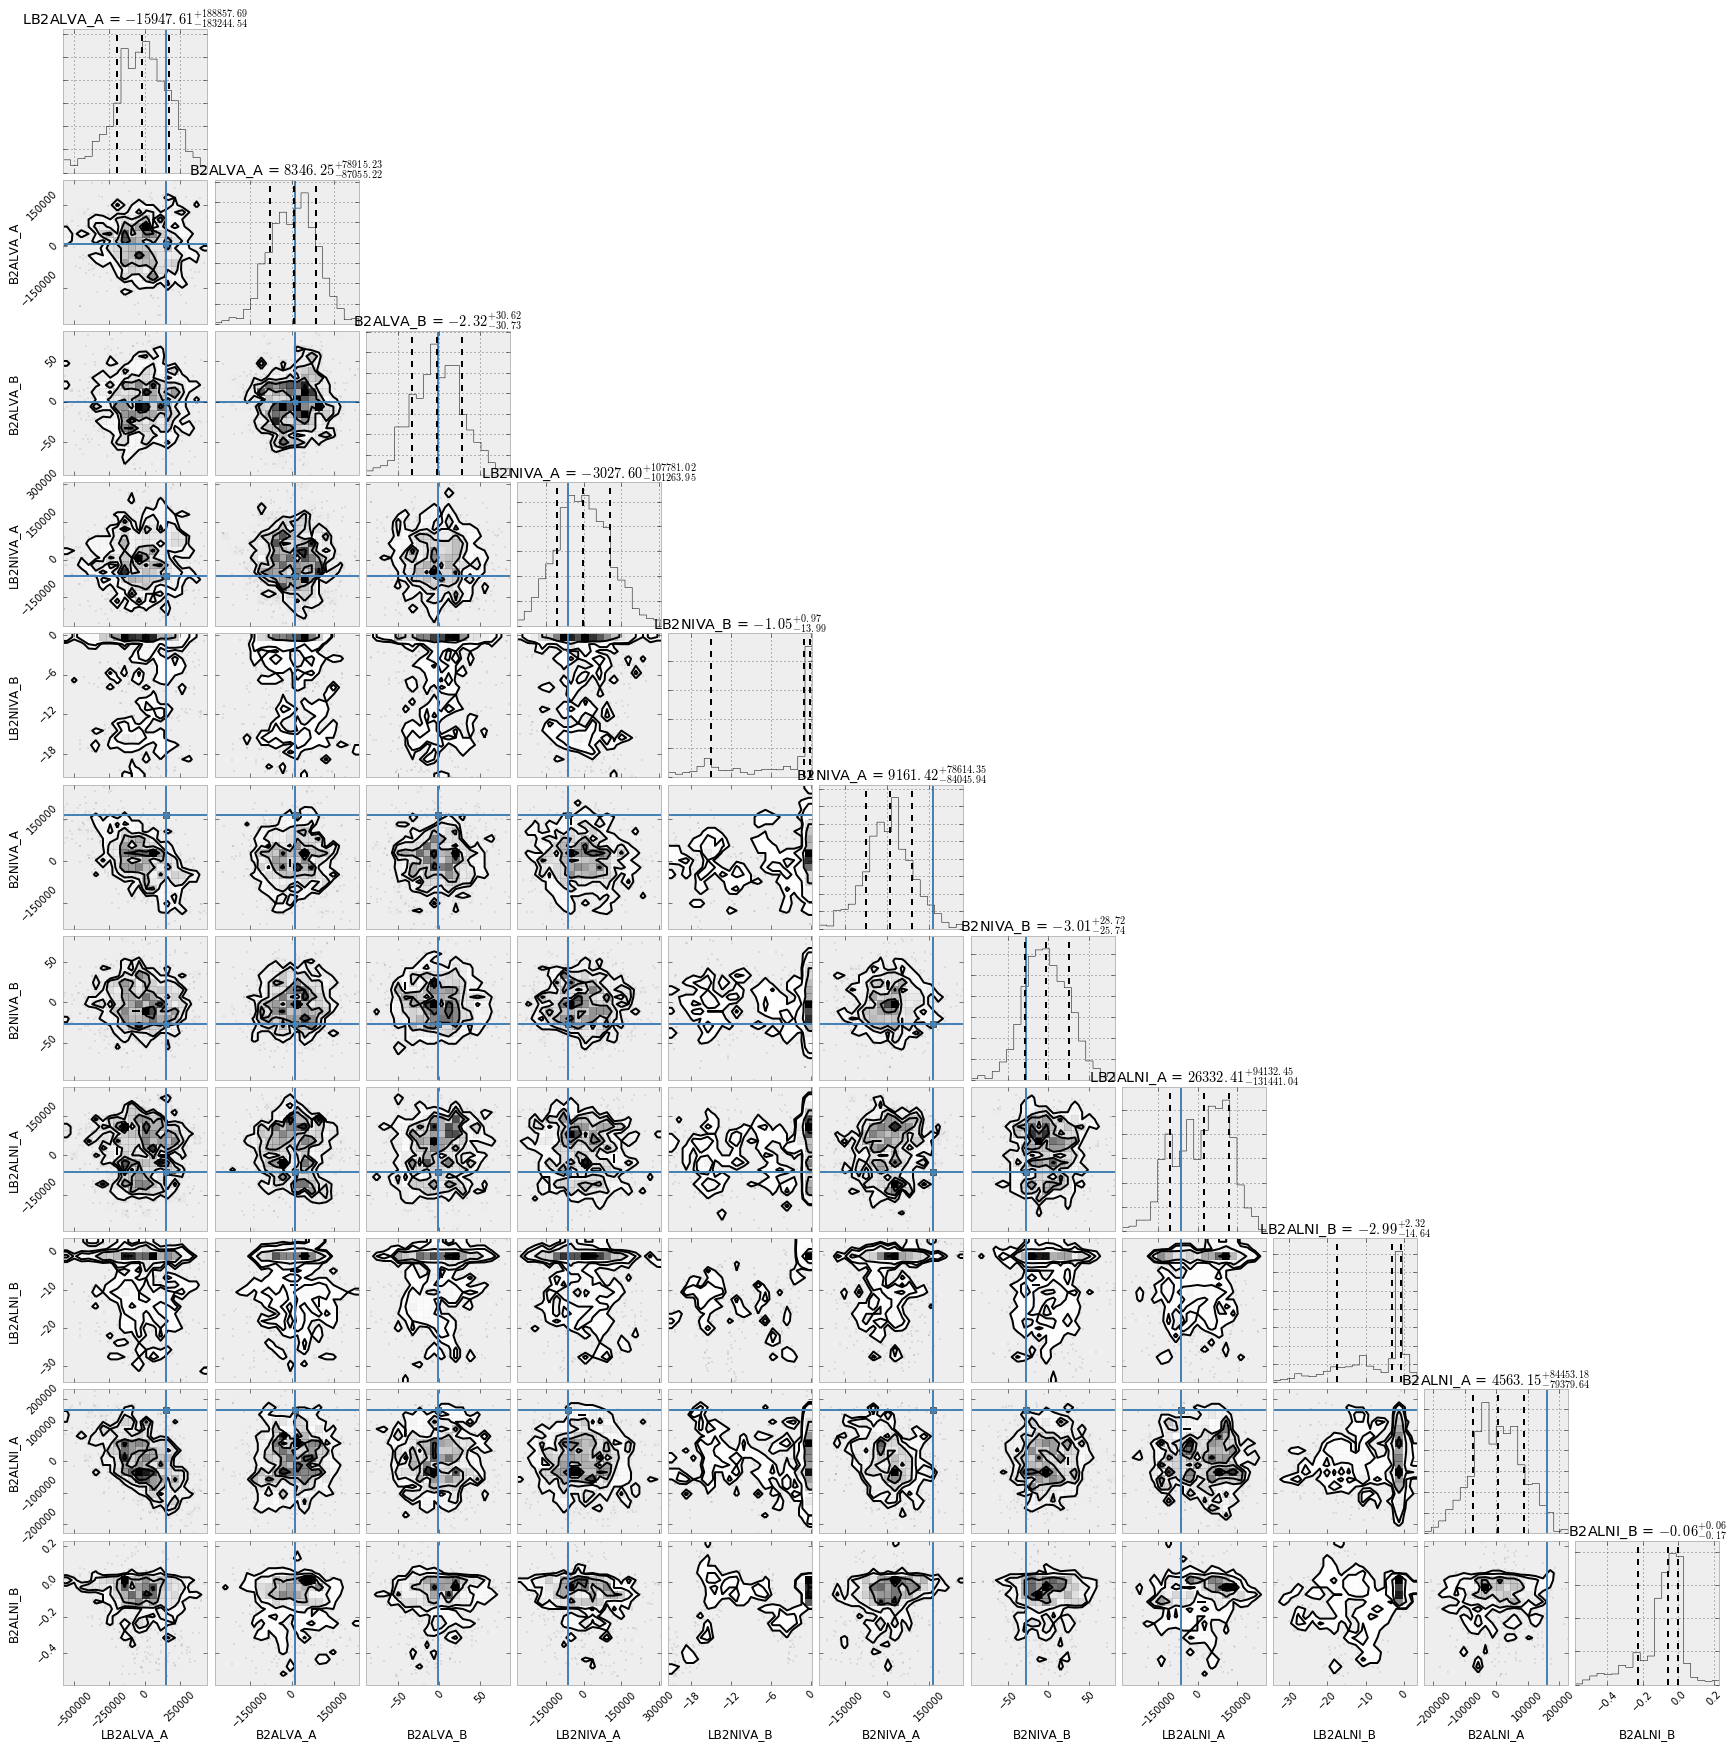

In [6]:
from corner import corner
from itertools import chain
data = np.vstack(chain([i.trace() for i in params])).T
corner(data, labels=[str(i) for i in params],
       quantiles=[0.16, 0.5, 0.84],
       truths=[150000, 10000, -1, -64024.38, 26.49419, 162397.3, -27.40575,
               -64024.38, 26.49419, 162397.3, -27.40575, -52440.88, 11.30117,
              -152397.3, 26.40575],
       show_titles=True, title_args={"fontsize": 40}).show()

ValueError: x and y must have same first dimension

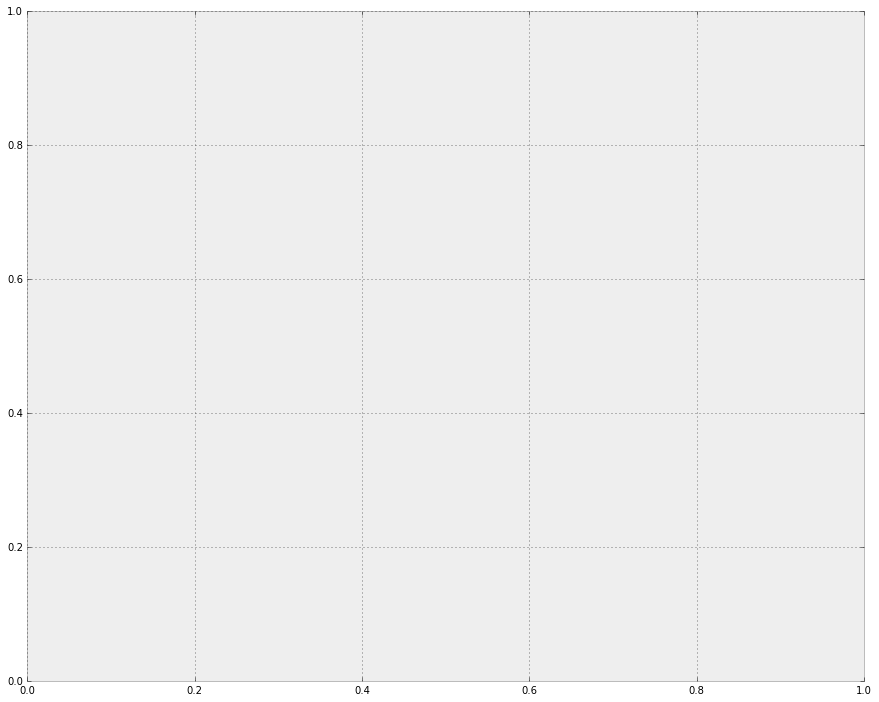

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15,12))
param_tr = [i.trace()[None, None, None].T for i in params]
fit = list(datasets.values())[0].calc_func(*param_tr).sel(T=slice(300, None))
mu = fit['HM'].values.mean(axis=0).flatten()
sigma = 2 * fit['HM'].values.std(axis=0).flatten()
plt.plot(fit['HM'].values.flatten(), mu, '-k', label='This work')
plt.fill_between(fit['HM'].values.flatten(), mu - sigma, mu + sigma, color='lightgray')
plt.plot(dataset_exps[0]['HM'], list(datasets.values())[0].exp_data.values.flatten(), label='Y. Wang 2009 (DFT)')
cp_from_dupin = calculate(Database('Al-Ni/Al-Ni-Dupin-2001.tdb'), ['AL', 'NI', 'VA'], ['BCC_B2'],
                          output='HM', points=np.array([[0, 1, 1, 0, 1]], dtype=np.float),
                          T=fit['T'].values.flatten(), P=101325)
plt.plot(cp_from_dupin['T'].values, cp_from_dupin['HM'].values.flatten(), label='Dupin 2001 (CALPHAD)')
plt.title('B2 Enthalpy', fontsize=20)
plt.xlabel('Temperature (K)', fontsize=20)
plt.ylabel('Molar Heat Capacity (J/K-mol-atom)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='best', fontsize=16)
plt.show()

In [9]:
list(datasets.values())[0].json

{u'components': [u'AL', u'NI', u'VA'],
 u'conditions': {u'P': 101325, u'T': 300},
 u'output': u'HM',
 u'phases': [u'BCC_B2'],
 u'reference': u'Chao Jiang 2009 SQS calculations',
 u'solver': {u'comment': u'BCC_B2 sublattice configuration (2SL)',
  u'mode': u'manual',
  u'sublattice_configuration': [[1, 0, 0, 1, 0, 0, 1],
   [0, 1, 0, 0, 1, 0, 1],
   [1, 0, 0, 0, 0.5, 0.5, 1],
   [1, 0, 0, 0, 0.6, 0.4, 1],
   [1, 0, 0, 0, 1, 0, 1],
   [0, 1, 0, 0.75, 0.25, 0, 1],
   [0, 1, 0, 0.5, 0.5, 0, 1],
   [1, 0, 0, 0.5, 0.5, 0, 1],
   [1, 0, 0, 0.25, 0.75, 0, 1],
   [0, 1, 0, 0.6, 0, 0.4, 1],
   [0, 1, 0, 0.5, 0, 0.5, 1]]},
 u'values': [[[9317.49855,
    9060.32543,
    -41921.43363,
    -57769.49473,
    -63985.67704,
    -50518.97713,
    -33114.31076,
    -19504.41974,
    -41109.66717,
    -39263.78274,
    -9087.71669]]]}